<a href="https://colab.research.google.com/github/100rab-S/TheForage-InsideSherpa-Quantium_virtual_experience-Internship/blob/main/V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import re

pd.set_option('display.max_columns', None)  # to display all rows and columns while printing.
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)

params = {'legend.fontsize': '15',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.figsize': (18, 7),
         'axes.prop_cycle': plt.cycler(color = plt.cm.Set1.colors),
         'image.cmap': 'Set1'}
plt.rcParams.update(params)

# plt.rcParams["image.cmap"] = "Set1"

# to change default color cycle
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
# plt.rcParams['figure.figsize'] = 10, 7

In [3]:
plt.style.use('dark_background')  # to change the default values of plt to our interest.

Read the data.

In [4]:
df = pd.read_csv('/content/drive/My Drive/Quantium Internship/Data/df1.csv', parse_dates= ['date'])
df.head()

,date,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price
0,2018-10-17,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
2,2018-11-10,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90
3,2019-03-09,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
4,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45


Inserted a column 'year_month' in the dataframe.

In [5]:
df.insert(1, 'year_month',df['date'].dt.to_period('M'))     # .dt.to_period('M')
df.head()

,date,year_month,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price
0,2018-10-17,2018-10,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00
1,2019-05-14,2019-05,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
2,2018-11-10,2018-11,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90
3,2019-03-09,2019-03,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10
4,2019-05-20,2019-05,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45


We have changed dtypes for simplicity  and easier operations.

In [6]:
cols_with_changed_dtype = {'prod_name': 'category', 'prod_qty': 'category',
                           'lifestage': 'category', 'premium_customer': 'category',
                           'prod_comp': 'category'}
df = df.astype(cols_with_changed_dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249668 entries, 0 to 249667
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              249668 non-null  datetime64[ns]
 1   year_month        249668 non-null  period[M]     
 2   store_nbr         249668 non-null  int64         
 3   lylty_card_nbr    249668 non-null  int64         
 4   txn_id            249668 non-null  int64         
 5   prod_nbr          249668 non-null  int64         
 6   prod_name         249668 non-null  category      
 7   prod_qty          249668 non-null  category      
 8   tot_sales         249668 non-null  float64       
 9   lifestage         249668 non-null  category      
 10  premium_customer  249668 non-null  category      
 11  prod_wt           249668 non-null  int64         
 12  prod_comp         249668 non-null  category      
 13  prod_price        249668 non-null  float64       
dtypes: c

We'll remove the stores which does not contain transaction data of all 12 months.

In [7]:
check = df.groupby('store_nbr')['year_month'].nunique()
check = check[check != 12]
print('Stores with less than 12 month transaction data:')
display(check)
stores_with_less_than_12_months = check.index.to_list()
del check

Stores with less than 12 month transaction data:


store_nbr
11     2 
31     2 
44     11
76     1 
85     1 
92     1 
117    11
177    11
193    3 
206    2 
218    11
252    2 
Name: year_month, dtype: int64

In [8]:
indices_to_drop = df[df['store_nbr'].isin(stores_with_less_than_12_months)].index
print(f'Shape before dropping: {df.shape}\n')
df = df.drop(indices_to_drop)
print(f'Shape after dropping: {df.shape}\n')
print(f'Number of samples that are dropped: {len(indices_to_drop)}')

Shape before dropping: (249668, 14)

Shape after dropping: (249441, 14)

Number of samples that are dropped: 227


In [ ]:
plt.rcParams.keys()

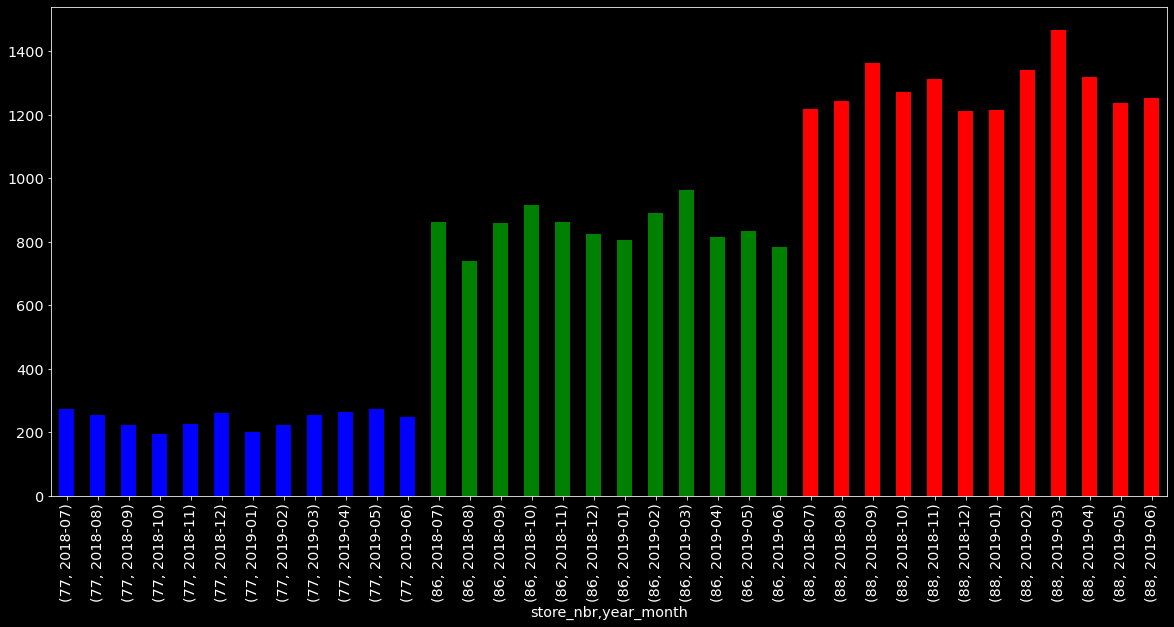

In [9]:
check = df[df['store_nbr'].isin([77, 86, 88])].groupby(['store_nbr', 'year_month'])['tot_sales'].sum() # code to plot
colors = []
for store, month in check.index:
    if store == 77:
        colors.append('b')
    elif store == 86:
        colors.append('g')
    else:
        colors.append('r')

check.plot(kind = 'bar', color = colors, figsize = (20, 9))
plt.show()
del check, colors

In [10]:
df['yearly_sale'] = df.groupby('store_nbr')['tot_sales'].transform('sum')
df['yearly_custs'] = df.groupby('store_nbr')['lylty_card_nbr'].transform('nunique')
df['monthly_sale'] = df.groupby(['store_nbr', 'year_month'])['tot_sales'].transform('sum')
df['monthly_custs'] = df.groupby(['store_nbr', 'year_month'])['lylty_card_nbr'].transform('nunique')
# df['monthly_txn'] = df.groupby(['store_nbr', 'year_month'])['txn_id'].agg({'txn_id': 'nunique'})

In [11]:
# df1 = df.copy()
# data = df.groupby(['store_nbr', 'month']).apply(lambda subdf: subdf['lylty_card_nbr'].count())
# # data['count'] = df.groupby(['store_nbr', 'month']).apply(lambda subdf: subdf['lylty_card_nbr'].count())
# data.head(25)

I need to add another column: average transaction per customer in the store.

In [12]:
avg_trans = df.groupby('store_nbr').apply(lambda subdf: (subdf['txn_id'].nunique() / subdf['yearly_custs'].unique()))
avg_trans = avg_trans.astype('float64')
df['avg_txn_per_cust'] = df['store_nbr'].map(avg_trans)

In [ ]:
# store_272 = df1.groupby('store_nbr').get_group(272)
# no_of_customers = store_272['no_of_custs'].unique()
# no_of_transactions = store_272['txn_id'].nunique()
# print(f'no of customers: {no_of_customers}')
# print(f'no of transactions: {no_of_transactions}')
# print((no_of_transactions / no_of_customers).round(4))

no of customers: [282]
no of transactions: 535
[1.8972]


In [13]:
df.head()

,date,year_month,store_nbr,lylty_card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,lifestage,premium_customer,prod_wt,prod_comp,prod_price,yearly_sale,yearly_custs,monthly_sale,monthly_custs,avg_txn_per_cust
0,2018-10-17,2018-10,1,1000,1,5,natural_chipco seasalt,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,natural_chipco,3.00,2237.3,335,178.0,40,1.608955
1,2019-05-14,2019-05,1,1307,348,66,ccs nacho cheese,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10,2237.3,335,207.1,43,1.608955
2,2018-11-10,2018-11,1,1307,346,96,ww original stacked chips,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,ww,1.90,2237.3,335,187.5,45,1.608955
3,2019-03-09,2019-03,1,1307,347,54,ccs original,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,ccs,2.10,2237.3,335,185.2,43,1.608955
4,2019-05-20,2019-05,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,smiths,1.45,2237.3,335,207.1,43,1.608955


"pre_df" is the dataset which contains samples only before the trial period.

In [14]:
pre_df = df[df['date'] < "2019-02-01"]

In [15]:
print(min(pre_df['date']), max(pre_df['date']))

2018-07-01 00:00:00 2019-01-31 00:00:00


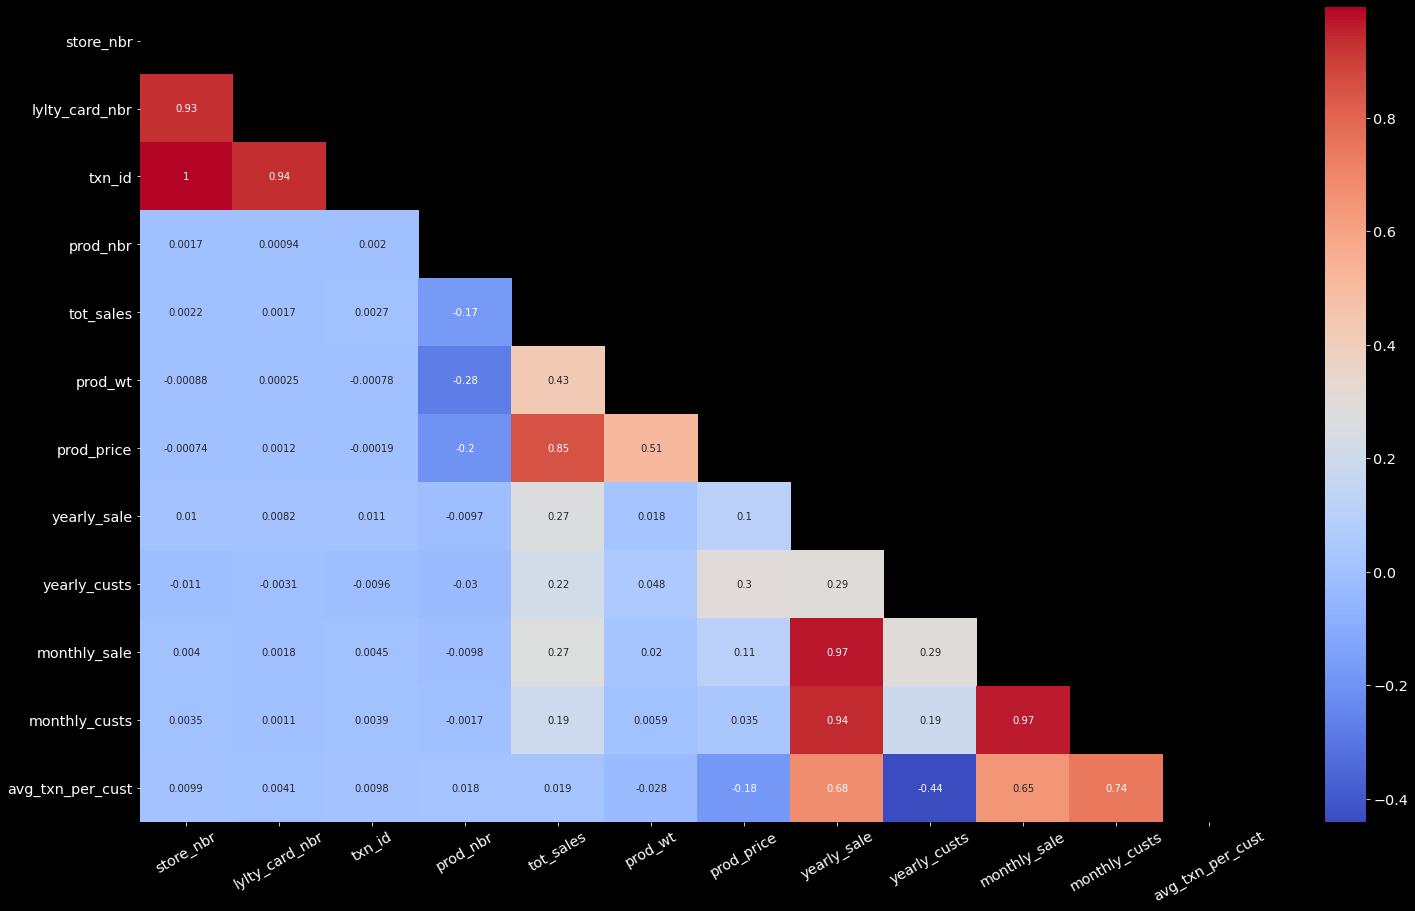

In [16]:
corrmat = pre_df.corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool))
plt.subplots(figsize = (25, 15))
sns.heatmap(corrmat, mask = mask, cmap = 'coolwarm', annot = True)
plt.xticks(rotation = 30)
plt.show()

In [ ]:
# grp = pre_df.groupby('store_nbr')
# for name, subdf in grp:
#     if name not in [77, 86, 88]:
#         #it is a control store
#         subdf
#     else:
#         # it is a trial store
#         pass

In [ ]:
pre_df.head()

'metrics_cols' are the features for correlation and ranking between trial stores and control stores.

In [17]:
metrics_cols = ['store_nbr', 'year_month', 'yearly_sale',
                'yearly_custs','monthly_sale', 'monthly_custs', 'avg_txn_per_cust']
# metrics_data = pre_trial_data.loc[:, metrics_cols]

In [18]:
metrics_df = pre_df.loc[:, metrics_cols].set_index(['store_nbr', 'year_month']).sort_values(by = ['store_nbr', 'year_month'])
metrics_df.drop_duplicates(inplace = True, keep = 'first')
metrics_df.head()

yearly_sale  yearly_custs  monthly_sale  monthly_custs  \
store_nbr year_month                                                           
1         2018-07     2237.3       335           191.6         48              
          2018-08     2237.3       335           168.4         41              
          2018-09     2237.3       335           268.1         57              
          2018-10     2237.3       335           178.0         40              
          2018-11     2237.3       335           187.5         45              

                      avg_txn_per_cust  
store_nbr year_month                    
1         2018-07     1.608955          
          2018-08     1.608955          
          2018-09     1.608955          
          2018-10     1.608955          
          2018-11     1.608955

In [ ]:
# metrics_df.xs('2018-09', level=1)

In [ ]:
# metrics_df.index.get_level_values('year_month').nunique()

7

Function to find correlation between trial stores and control stores one by one.

In [19]:
def calc_corr(trial_store):
    '''
    input: It takes one trial store to compare other stores with.
    output: New dataframe with correlation and mean correlation.
    '''
    a=[]
    metrics = metrics_df[['monthly_sale', 'monthly_custs']] 
    for i in metrics.index:
        a.append(metrics.loc[trial_store].corrwith(metrics.loc[i[0]]))
    subdf= pd.DataFrame(a)
    subdf.index = metrics.index
    subdf = subdf.drop_duplicates()
    subdf.index=[s[0] for s in subdf.index]
    subdf.index.name="store_nbr"
    subdf = subdf.abs()
    subdf['mean_corr'] = subdf.mean(axis=1)
    subdf.sort_values(by = 'mean_corr', ascending = False, inplace = True)
    return subdf

## Correlation with trial store: 77

In [20]:
corr_77 = calc_corr(77).drop(77)
# corr_77 = corr_77.drop(77)
corr_77.head(5)

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
233,0.976651,0.964970,0.970811
119,0.836712,0.950144,0.893428
41,0.819951,0.842018,0.830985
254,0.690476,0.956769,0.823622
50,0.917940,0.724430,0.821185


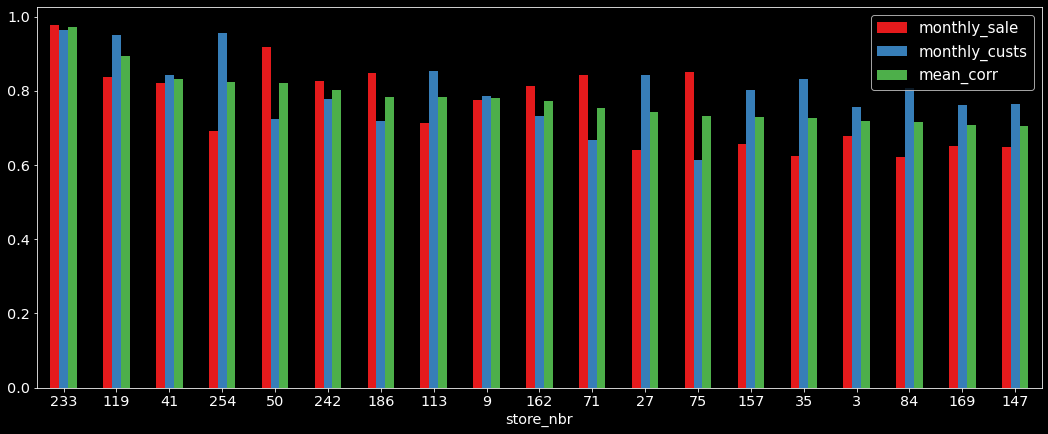

In [34]:
corr_77[corr_77['mean_corr'].abs() > 0.7].plot(kind = 'bar', rot = 0)

## Correlation with trial store: 86

In [35]:
corr_86 = calc_corr(86).drop(86)
corr_86.head()

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
155,0.852169,0.824667,0.838418
114,0.797520,0.875624,0.836572
260,0.851237,0.805041,0.828139
56,0.795140,0.799344,0.797242
120,0.891578,0.606359,0.748968


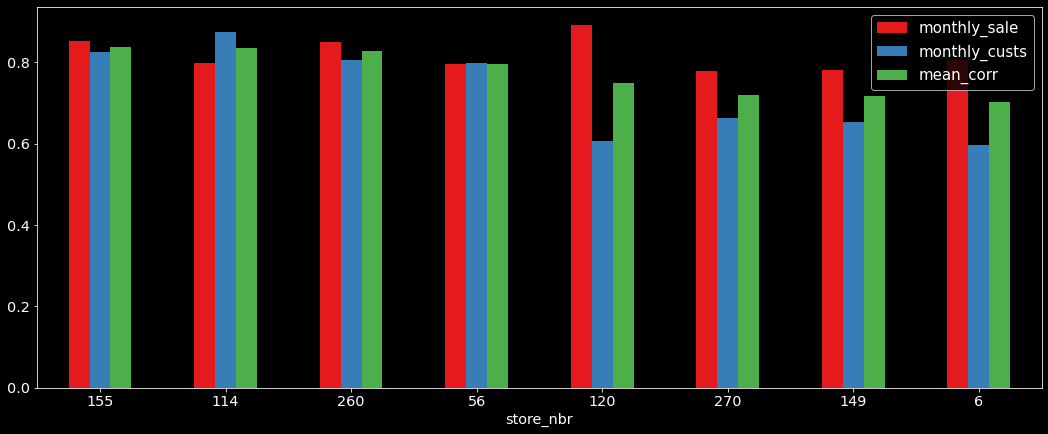

In [36]:
corr_86[corr_86['mean_corr'].abs() > 0.7].plot(kind = 'bar', rot = 0)

## Correlation with trial store: 88

In [37]:
corr_88 = calc_corr(88).drop(88)
corr_88.head()

,monthly_sale,monthly_custs,mean_corr
store_nbr,,,
14,0.599664,0.975727,0.787695
141,0.718477,0.643611,0.681044
204,0.871969,0.458144,0.665057
1,0.846112,0.450833,0.648472
235,0.834842,0.430326,0.632584


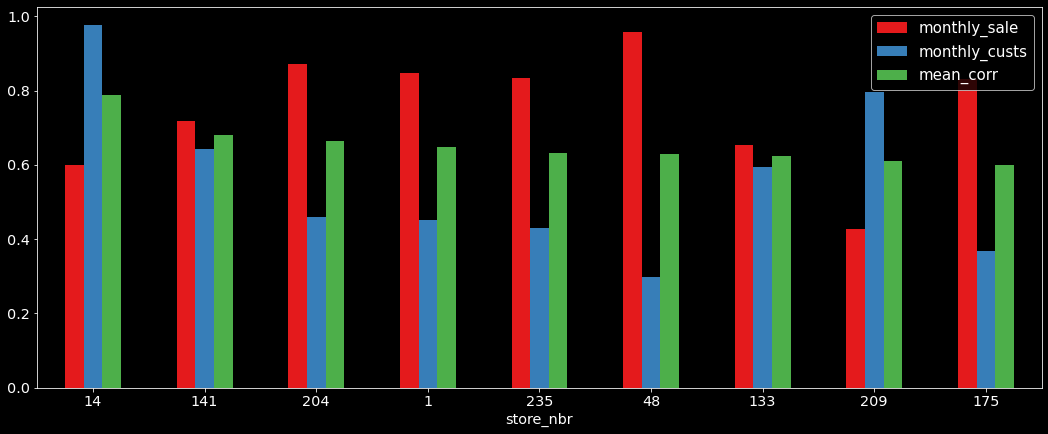

In [40]:
corr_88[corr_88['mean_corr'].abs() > 0.6].plot(kind = 'bar', rot = 0)